In [1]:
import tensorflow as tf
import numpy as np
import tensorflow.keras
import os
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sVAE_utils import plot_results, build_vae, eval_vae, build_pnn, build_vae_s, build_vae_corrupt,recon_vae
from process_data import load_train_data, process_daq, sub_train_test, sub_split, sub_split_loo, sub_split_stat, norm_sub, add_noise, extract_feats
from lda import train_lda, predict, eval_lda
from gpu import set_gpu
from matplotlib import pyplot as plt

set_gpu()

Num GPUs Available:  1


In [2]:
## LOAD DATA
# Load raw EMG data
feat,params,daq = load_train_data('train_data_raw_AB.mat')
raw = process_daq(daq,params)

rem_ind = params[:,5]!=5
feat = feat[rem_ind,:]
raw = raw[:,:,rem_ind]
params = params[rem_ind,:]

# Reshape data for CNN architecture
raw = raw[::2,:,:].transpose(2,1,0)
feat_sq = feat.reshape(feat.shape[0],6,10)

# Loop

In [3]:
## INITIALIZE VARIABLES ##

# VAE hyperparameters
batch_size = 128
latent_dim = 12
epochs = 30
feat_type = 'raw'
data_in = raw
# data_in = norm_sub(feat_sq, params)

acc_all = np.zeros([np.max(params[:,0]),4])
for sub in range(1,2):#np.max(params[:,0])+1):
    for train_grp in range(1,2):#np.max(params[:,3])+1):
        foldername = 'models' + '_' + str(train_grp)

        if not os.path.exists(foldername):
            os.makedirs(foldername)

        filename = foldername + '/vae_noise1' + feat_type + '_AB' + str(sub)

        # Index EMG data
        x_train_noise, x_train, y_train = add_noise(raw,params,sub)
        x_test_noise = x_train_noise[:x_train_noise.shape[0]//3,:,:]
        x_train_noise = x_train_noise[x_train_noise.shape[0]//3:,:,:]
        x_test = x_train[:x_train.shape[0]//3,:,:]
        x_train = x_train[x_train.shape[0]//3:,:,:]
        y_test = y_train[:y_train.shape[0]//3,:]
        y_train = y_train[y_train.shape[0]//3:,:]

        # Check if training data exists
        if (type(x_train) == np.ndarray):
            print('Running sub ' + str(sub) + ', model ' + str(train_grp))
            
            ## SUBJECT SPECIFIC SUPERVISED VAE
            # Scale data
            scaler = MinMaxScaler(feature_range=(-1,1))
            x_train_noise_vae = scaler.fit_transform(x_train_noise.reshape(x_train_noise.shape[0],-1)).reshape(x_train_noise.shape)
            x_train_vae = scaler.transform(x_train.reshape(x_train.shape[0],-1)).reshape(x_train.shape)
            x_test_vae = scaler.transform(x_test_noise.reshape(x_test_noise.shape[0],-1)).reshape(x_test_noise.shape)
            # x_train_noise_vae = x_train_noise
            # x_train_vae = x_train
            # x_test_vae = x_test_noise
            # Build VAE
            vae, encoder, decoder,clf = build_vae_corrupt(latent_dim, y_train.shape[1], input_type=feat_type)

            # # Fit and save VAE
            vae.fit(x_train_noise_vae, [x_train_vae,y_train],epochs=epochs,batch_size=batch_size)
            

            vae_w = vae.get_weights()
            enc_w = encoder.get_weights()
            dec_w = decoder.get_weights()
            clf_w = clf.get_weights()

            # with open(filename + '.p', 'rb') as f:
                # scaler, vae_w, enc_w, dec_w, clf_w, w, c, w_aligned,c_aligned = pickle.load(f)
            
            vae.set_weights(vae_w)
            encoder.set_weights(enc_w)
            decoder.set_weights(dec_w)
            clf.set_weights(clf_w)

            y_pred, acc_all[sub-1,0] = eval_vae(vae, x_test_vae, y_test)

            ## BASELINE LDA
            # Train LDA classifier
            x_train_lda = extract_feats(x_train_vae)
            x_test_lda = extract_feats(x_test_vae)
            y_train_lda = np.argmax(y_train, axis=1)[...,np.newaxis]
            y_test_lda = np.argmax(y_test, axis=1)[...,np.newaxis]
            w,c = train_lda(x_train_lda,y_train_lda)
            acc_all[sub-1,2] = eval_lda(w, c, x_test_lda, y_test_lda)
            # acc_lda = eval_lda(w, c, x_test, y_test)

            # Train LDA classifier with corrupted data
            x_train_lda2 = extract_feats(x_train_noise)
            y_train_lda2 = np.argmax(y_train, axis=1)[...,np.newaxis]
            w,c = train_lda(x_train_lda2,y_train_lda2)
            acc_all[sub-1,3] = eval_lda(w, c, x_test_lda, y_test_lda)

            # encoder.set_weights(enc_w)
            _, _, x_train_aligned = encoder.predict(x_train_vae)
            _,_, x_test_aligned = encoder.predict(x_test_vae)
            y_train_aligned = np.argmax(y_train, axis=1)[...,np.newaxis]
            y_test_aligned = np.argmax(y_test, axis=1)[...,np.newaxis]
            w_aligned, c_aligned = train_lda(x_train_aligned,y_train_aligned)
            acc_all[sub-1,1] = eval_lda(w_aligned, c_aligned, x_test_aligned, y_test_aligned)

            # Pickle variables
            with open(filename  + '.p', 'wb') as f:
                pickle.dump([scaler, vae_w, enc_w, dec_w, clf_w, w, c, w_aligned,c_aligned],f)

Running sub 1, model 1
Train on 16334 samples
Epoch 1/30
16334/16334 [==============================] - 5s 322us/sample - loss: -0.7149 - decoder_loss: -2.7499 - clf_loss: 2.0326
Epoch 2/30
16334/16334 [==============================] - 2s 122us/sample - loss: -2.0354 - decoder_loss: -3.5285 - clf_loss: 1.4920
Epoch 3/30
16334/16334 [==============================] - 2s 121us/sample - loss: -2.5750 - decoder_loss: -3.7815 - clf_loss: 1.2061
Epoch 4/30
16334/16334 [==============================] - 2s 121us/sample - loss: -2.8092 - decoder_loss: -3.8892 - clf_loss: 1.0801
Epoch 5/30
16334/16334 [==============================] - 2s 120us/sample - loss: -2.0586 - decoder_loss: -3.7094 - clf_loss: 1.6501
Epoch 6/30
16334/16334 [==============================] - 2s 119us/sample - loss: -2.4606 - decoder_loss: -3.9354 - clf_loss: 1.4741
Epoch 7/30
16334/16334 [==============================] - 2s 118us/sample - loss: -2.7142 - decoder_loss: -3.9520 - clf_loss: 1.2376
Epoch 8/30
16334/16334 

In [3]:
ind = (params[:,0] == 1) & (params[:,3] == 2)
raw1 = raw[ind,:,:]
params1 = params[ind,:]
x,x2,y = add_noise(raw, params, 1)


In [6]:
train_grp = 1
feat_type = 'raw'
foldername = 'models' + '_' + str(train_grp)
filename = foldername + '/vae_noise' + feat_type + '_AB' + str(1)
with open(filename + '.p', 'rb') as f:
    scaler, vae_w, enc_w, dec_w, clf_w, w, c, w_aligned,c_aligned = pickle.load(f)

vae, encoder, decoder,clf = build_vae_corrupt(12, 7, input_type=feat_type)
vae.set_weights(vae_w)
encoder.set_weights(enc_w)
decoder.set_weights(dec_w)
clf.set_weights(clf_w)
x_1 = scaler.transform(x.reshape(x.shape[0],-1)).reshape(x.shape)
x2_1 = scaler.transform(x2.reshape(x2.shape[0],-1)).reshape(x2.shape)
recon = vae.predict(x_1)[0]

In [19]:
recon = vae.predict(x_1)[0]

In [18]:
test = x2.reshape(x2.shape[0],-1).reshape(x2.shape)

In [12]:
params1[500,:]

array([    1,     2, 41451,     2,     6,     1])

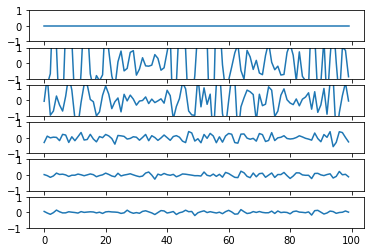

In [13]:
for ch in range(0,6):
    plt.subplot(6,1,ch+1)
    plt.plot(x[4000,ch,:])
    plt.ylim(-1,1)
# plt.subplot(x_test_vae[0,0,:])

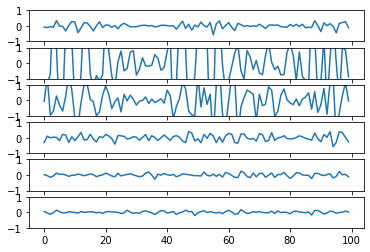

In [14]:
for ch in range(0,6):
    plt.subplot(6,1,ch+1)
    plt.plot(x2[4000,ch,:])
    plt.ylim(-1,1)


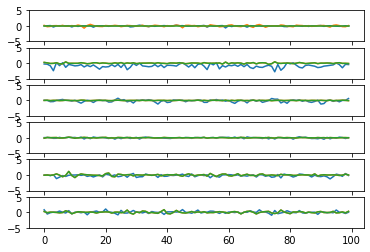

In [19]:
recon_inv = scaler.inverse_transform(recon.reshape(recon.shape[0],-1)).reshape(recon.shape)
for ch in range(0,6):
    plt.subplot(6,1,ch+1)
    plt.plot(recon_inv[4500,ch,:])
    plt.plot(x2[4500,ch,:])
    plt.plot(x[4500,ch,:])
    plt.ylim(-5,5)

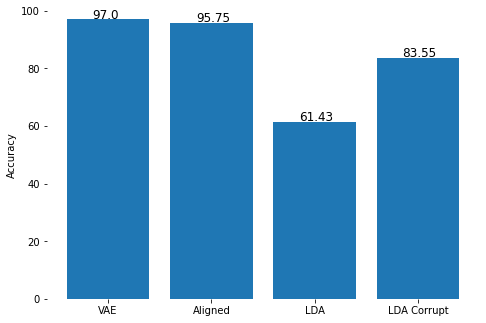

In [40]:
from scipy.stats import sem
from matplotlib import pyplot as plt

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
temp = np.mean(acc_all[:6,:],axis=0)*100
ax.bar(['VAE','Aligned','LDA','LDA Corrupt'],temp)
ax.set_ylabel('Accuracy')
ax.set_ylim((0,100))
plt.box(on=None)
for i, v in enumerate(temp):
    ax.text(i-.15, v+.4, str(round(v,2)), color='black',fontsize=12)